# Web Scraping

In [118]:
"""
# @Author:  Zirui Zhou
# @Date:    2021/10/13 23:19:37
# @Contact: zirui.zhou19@student.xjtlu.edu.cn
"""
pass

In [51]:
import queue
import threading


class QueueThread(threading.Thread):
    """A simple class to support tasks for queue in thread.

    Attributes:
        func: A function for the target task.
        queue: A queue.Queue object to acquire params for the function.
    """
    def __init__(self, func, queue):
        super().__init__()
        self.func = func
        self.queue = queue
        self.daemon = True

    def run(self):
        """Start function.
        """
        while True:
            # Exit the thread if there is no item in the queue.
            try:
                self.func(*self.queue.get_nowait())
            except queue.Empty:
                return
            self.queue.task_done()

In [52]:
import requests
import time


class CommonRequest:
    """A simple class to support basic requests.

    Attributes:
        retry_c: A list of HTTP status codes for retrying.
        retry_e: A tuple of Exceptions for retrying.
        retry_interval: A integer of the interval (second) between two retry requests.
    """
    retry_c = [
        requests.codes.too_many_requests,
    ]
    retry_e = (
        requests.exceptions.ConnectionError,
        # For Exceptions raised from `retry_c`.
        requests.exceptions.HTTPError,
        requests.exceptions.Timeout,
    )
    retry_interval = 1

    @classmethod
    def common_get(cls, url, params=None, timeout=5, logger=None):
        """A function for common get request.

        Args:
            url: A string of the request url.
            params: A dictionary of the params.
            timeout: A integer of the timeout (seconds).
            logger: A logger object for logging.

        Returns:
            A request.Response object of the target request.
        """
        return cls.retry(
            requests.get,
            logger=logger,
            url=url,
            params=params,
            timeout=timeout
        )

    @classmethod
    def retry(cls, func, logger=None, *args, **kwargs):
        """A helper function to retry requests when encountering errors and exceptions.

        Args:
            func: A function of the target request.
            logger: A logger object for logging errors and exceptions.
            *args: A list of params for the request function.
            **kwargs: A dictionary of params for the request function.

        Returns:
            A request.Response object of the target request.
        """
        while True:
            try:
                response = func(*args, **kwargs)
                if response.status_code in cls.retry_c:
                    response.raise_for_status()
                return response
            except cls.retry_e as e:
                if logger:
                    logger.info(e)
                time.sleep(cls.retry_interval)
                continue

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer


title_similarity_threshold = 0.5

def compare_title(query_title, resp_title, resp_subtitle):
    """Get the titles' text similarity by TFIDF.

    Args:
        query_title: A string of the original title.
        resp_title: A string of the target title.
        resp_subtitle: A string of the target subtitle.

    Returns:
         An integer of the text similarity of the titles.
    """

    # The original title is compared with target title and target title with subtitle.
    corpus = [query_title,
              resp_title,
              f"{resp_title} {resp_subtitle}"]

    # The stop_words is disabled due to the short length of the corpus.
    vect = TfidfVectorizer(min_df=1, stop_words=None)
    tfidf = vect.fit_transform(corpus)
    # The similarity is the maximum of the results.
    similarity = max((tfidf * tfidf.T).A[0, 1:])
    return similarity

In [54]:
import logging
import os
import sys
import time


def get_logger_handler(log_path=None, is_print=False, level=logging.DEBUG):
    """Generate the logger handlers.

    Args:
        log_path: A string of the log file path. None for no file output.
        is_print: A boolean of whether to print the log in console.
        level: A logging Level Object to set the logging level.

    Returns:
        A list of the logger's handlers.
    """
    handlers = list()
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    if is_print:
        handler = logging.StreamHandler(sys.stdout)
        handler.setLevel(level)
        handler.setFormatter(formatter)
        handlers.append(handler)

    if log_path:
        handler = logging.FileHandler(log_path, encoding="utf-8")
        handler.setLevel(level)
        handler.setFormatter(formatter)
        handlers.append(handler)

    return handlers

time_format = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime())
log_path = "./log"
os.makedirs(log_path, exist_ok=True)

book_logger = logging.Logger("Book Scrape", level=logging.INFO)
book_logger.handlers = get_logger_handler(os.path.join(log_path, f"book {time_format}.log"))

net_logger = logging.Logger("Connection", level=logging.INFO)
net_logger.handlers = get_logger_handler(os.path.join(log_path, f"net {time_format}.log"))

In [55]:
import logging
import time


class DebugTimer:
    """A simple class to record runtime of some codes.

    Attributes:
        start_time: A double of the timer's start time.
        end_time: A double of the timer's end time.
        desc: A string of the description of target process.
        print_format: A string of format of print().
        logger: A logger to output the information.
    """
    start_time = 0
    end_time = 0
    desc = str()
    print_format = str()
    logger = logging.Logger("DebugTimer", level=logging.INFO)

    def __init__(self, desc="unknown process", logger=None):
        self.desc = desc
        self.print_format = "The duration of {} is: {} s.\n"
        self.logger.handlers = logger.handlers if logger else get_logger_handler(is_print=True)

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end()

    def start(self):
        """Start the timer.
        """
        self.start_time = time.perf_counter()

    def end(self):
        """End the timer.
        """
        self.end_time = time.perf_counter()
        self.logger.info(self.print_format.format(self.desc, self.end_time - self.start_time))

In [7]:
from bs4 import BeautifulSoup
import json
import re
import requests


class ScrapeBookParser:
    """A simple class to parse the book information from a Book Scrape page.

    References: https://books.toscrape.com/index.html

    Attributes:
        book_soup: A BeautifulSoup Object of the Book Scrape page.
    """
    rating_str_to_num = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "five": 5,
    }

    def __init__(self, book_soup):
        self.book_soup = book_soup
        self.book_main_soup = self.book_soup.find("div", "product_main")
        self.book_table_soup = self.book_soup.find("table", "table table-striped")

    def get_title(self):
        return self.book_main_soup.h1.string

    def get_review_num(self):
        return int(self.book_table_soup.find("th", text="Number of reviews").find_next_sibling("td").string)

    def get_rating(self):
        return self.rating_str_to_num[self.book_main_soup.find("p", "star-rating")["class"][1].lower()]

    def get_description(self):
        desc_soup = self.book_soup.find("div", id="product_description")
        return desc_soup.find_next("p").string if desc_soup else None

    def get_price_excl_tax(self):
        return self.book_table_soup.find("th", text="Price (excl. tax)").find_next_sibling("td").string

    def get_price_excl_tax_num(self):
        price = self.get_price_excl_tax()
        price = get_number_pattern().search(price)
        return float(price.group()) if price else None

    def get_price_incl_tax(self):
        return self.book_table_soup.find("th", text="Price (incl. tax)").find_next_sibling("td").string

    def get_price_incl_tax_num(self):
        price = self.get_price_incl_tax()
        price = get_number_pattern().search(price)
        return float(price.group()) if price else None

    def get_product_type(self):
        return self.book_table_soup.find("th", text="Product Type").find_next_sibling("td").string

    def get_category(self):
        return self.book_soup.find("ul", "breadcrumb").find("li", "active").find_previous_sibling("li").a.string

    def get_availability(self):
        return self.book_table_soup.find("th", text="Availability").find_next_sibling("td").string

    def get_availability_num(self):
        available = self.get_availability()
        available = get_number_pattern().search(available)
        return int(available.group()) if available else None

class GoogleBookParser:
    """A simple class to parse the book information from Google Books API.

    References: https://developers.google.com/books

    Attributes:
        book_info: A dictionary of the book information from Google Books API.
    """
    def __init__(self, book_info):
        self.book_info = book_info

    def has_title(self):
        return "title" in self.book_info["volumeInfo"]

    def has_self_link(self):
        return "selfLink" in self.book_info

    def get_title(self):
        return self.book_info["volumeInfo"].get("title", "")

    def get_self_link(self):
        return self.book_info["selfLink"]

    def get_subtitle(self):
        return self.book_info["volumeInfo"].get("subtitle", "")

    def get_authors(self):
        return self.book_info["volumeInfo"].get("authors", [])

    def get_authors_str(self, sep=", "):
        return sep.join(self.get_authors())

    def get_average_rating(self):
        return self.book_info["volumeInfo"].get("averageRating", None)

    def get_rating_count(self):
        return self.book_info["volumeInfo"].get("ratingsCount", None)

    def get_page_count(self):
        return self.book_info["volumeInfo"].get("pageCount", None)

    def get_list_price(self):
        list_price = self.book_info.get("saleInfo", dict()).get("listPrice", None)
        return f"{list_price['amount']} {list_price['currencyCode']}" if list_price else None

    def get_retail_price(self):
        retail_price = self.book_info.get("saleInfo", dict()).get("retailPrice", None)
        return f"{retail_price['amount']} {retail_price['currencyCode']}" if retail_price else None

    def get_categories(self):
        return self.book_info["volumeInfo"].get("categories", [])

    def get_published_date(self):
        return self.book_info["volumeInfo"].get("publishedDate", None)

def get_book_item():
    return {
        "Title of Book": ScrapeBookParser.get_title,
        "Number of reviews": ScrapeBookParser.get_review_num,
        "Rating": ScrapeBookParser.get_rating,
        "Description": ScrapeBookParser.get_description,
        "Price": ScrapeBookParser.get_price_excl_tax_num,
        "Product Type": ScrapeBookParser.get_product_type,
        "Book category": ScrapeBookParser.get_category,
        "Availability": ScrapeBookParser.get_availability_num,
    }

def get_book_extra_item():
    return {
        "Google Author": GoogleBookParser.get_authors_str,
        "Google Page Count": GoogleBookParser.get_page_count,
        "Google Rating": GoogleBookParser.get_average_rating,
        "Google Rating Count": GoogleBookParser.get_rating_count,
        "Google Price": lambda p: GoogleBookParser.get_list_price(p) or GoogleBookParser.get_retail_price(p),
        "Google Category": lambda p: next(iter(GoogleBookParser.get_categories(p)), None),
        "Google Published Date": GoogleBookParser.get_published_date,
    }

def get_book_list_info():
    """Get the main book index information.

    Returns:
        A list which contains total number, first index in one page, last index in one page (i.e. number in one page).
    """
    response = CommonRequest.common_get("https://books.toscrape.com/index.html", logger=net_logger)
    soup = BeautifulSoup(response.content, "html.parser")
    return [int(item.string) for item in soup.find("form", "form-horizontal", method="get").find_all("strong")]

def get_book_url_list(page, url_list):
    """Get the book url list.

    Args:
        page: An integer of the target page index.
        url_list: A list to put the urls into.
    """
    response = CommonRequest.common_get(f"https://books.toscrape.com/catalogue/page-{page}.html", logger=net_logger)
    soup = BeautifulSoup(response.content, "html.parser")
    urls = [item.a["href"] for item in soup.findAll("article", "product_pod")]
    url_list.extend(urls)

def get_book_info(url, book_info_list, pbar):
    """Get one book detailed information.

    Args:
        url: A string of the sub link of one book.
        book_info_list: A list of all the books' information.
        pbar: A tqdm.tqdm Object for the progress of book scrapy.
    """
    response = CommonRequest.common_get(f"https://books.toscrape.com/catalogue/{url}", logger=net_logger)
    soup = BeautifulSoup(response.content, "html.parser")
    book_parser = ScrapeBookParser(soup)

    book_info = [func(book_parser) for func in get_book_item().values()]

    # List append is thread-safe.
    book_info_list.append(book_info)
    pbar.update(1)

def get_book_extra_info(book_title, book_info, pbar, check_num=3):
    """Get one book extra information from multi-source.

    Args:
        book_title: A string of the target book title.
        book_info: A list of the book information from ToScrape.
        pbar: A tqdm.tqdm Object for the progress of book scrapy.
        check_num: A integer of the number of results to check the similarity.

    Returns:
        A list of the extra information to concat with the basic one.
    """
    google_url = f'https://www.googleapis.com/books/v1/volumes'

    # Remove the possible Vol. info where # serves as stop mark which misleads the query.
    # For example: I Hate Fairyland, Vol. 1: Madly Ever After (I Hate Fairyland (Compilations) #1-5)
    query_title = re.sub(r"\(.*#.*\)", "", book_title)

    response = CommonRequest.common_get(
        google_url,
        {
            # Note that the query title will be quoted automatically.
            "q": query_title,
            "langRestrict": "en",
        },
        logger=net_logger
    )
    google_books = json.loads(response.content)
    google_books = google_books['items'] if 'items' in google_books.keys() else []
    book_extra_info = [None for _ in get_book_extra_item().values()]

    for google_book_info in google_books[:check_num]:
        book_parser = GoogleBookParser(google_book_info)

        # Sometimes, the query results is incomplete, which needs further request.
        if not book_parser.has_title() and book_parser.has_self_link():
            new_response = CommonRequest.common_get(book_parser.get_self_link(), logger=net_logger)
            google_book_info = json.loads(new_response.content)
            book_parser = GoogleBookParser(google_book_info)

        # Neglect the book which has no title information.
        if not book_parser.has_title():
            continue

        google_title = book_parser.get_title()
        google_subtitle = book_parser.get_subtitle()

        similarity = compare_title(query_title, google_title, google_subtitle)
        book_logger.info(
            f"\nRequest Title: {query_title}"
            f"\nResponse Title: {google_title}"
            f"\nResponse Subtitle: {google_subtitle}"
            f"\nSimilarity: {similarity}"
            f"\nRequest Url: {response.request.url}"
            f"\n"
        )

        # If the similarity exceeds the threshold, just judge that the two books are the same one.
        # Note that this may lead to some inaccuracy, if threshold is assigned to an unreasonable value, as it is a hyperparameter.
        # Refer to the book log for further fine-tune.
        if similarity > title_similarity_threshold:
            # Sometimes, the query results is incomplete, which needs further request.
            # However, this will double the request time, due to Google limit rate.
            # Thus, there do not apply self link recheck.
            book_extra_info = [func(book_parser) for func in get_book_extra_item().values()]
            break

    book_info.extend(book_extra_info)
    pbar.update(1)

def get_number_pattern():
    return re.compile(r"\d*\.\d+|\d+")

In [57]:
import pandas
import math
import tqdm


book_url_list = list()
book_info_list = list()
result_filepath = "./Zirui_Zhou+1927924.csv"

book_url_queue = queue.Queue()
scrape_book_queue = queue.Queue()
google_book_queue = queue.Queue()

with DebugTimer("Getting Book List Info"):
    total, _, step = get_book_list_info()
    print(f"The total book number is {total}.")

with DebugTimer("Getting Book Url List"):
    for idx in range(math.ceil(total/step)):
        book_url_queue.put((idx+1, book_url_list, ))
    for _ in range(10):
        QueueThread(get_book_url_list, book_url_queue).start()
    book_url_queue.join()

with DebugTimer("Getting Scrape Book Info"):
    scrape_pbar = tqdm.tqdm(range(total), position=0, leave=True)
    for url in book_url_list:
        scrape_book_queue.put((url, book_info_list, scrape_pbar,))
    for _ in range(20):
        QueueThread(get_book_info, scrape_book_queue).start()
    scrape_book_queue.join()

with DebugTimer("Writing CSV"):
    headers = list(get_book_item().keys())
    pandas.DataFrame(book_info_list, columns=headers).to_csv(result_filepath, sep='\t')

with DebugTimer("Getting Google Book Info"):
    google_pbar = tqdm.tqdm(range(total), position=0, leave=True)
    for book_info in book_info_list:
        google_book_queue.put((book_info[0], book_info, google_pbar, ))
    for _ in range(20):
        QueueThread(get_book_extra_info, google_book_queue).start()
    google_book_queue.join()

with DebugTimer("Writing CSV"):
    headers = list(get_book_item().keys()) + list(get_book_extra_item().keys())
    pandas.DataFrame(book_info_list, columns=headers).to_csv(result_filepath, sep='\t')

print("Done")

The total book number is 1000.
2022-10-20 00:31:27,542 - DebugTimer - INFO - The duration of Getting Book List Info is: 2.75594479998108 s.

2022-10-20 00:31:40,049 - DebugTimer - INFO - The duration of Getting Book Url List is: 12.50624550000066 s.



100%|██████████| 1000/1000 [01:59<00:00,  1.38it/s]

2022-10-20 00:33:39,460 - DebugTimer - INFO - The duration of Getting Scrape Book Info is: 119.41021170001477 s.

2022-10-20 00:33:39,499 - DebugTimer - INFO - The duration of Writing CSV is: 0.03800490003777668 s.



100%|██████████| 1000/1000 [09:24<00:00,  8.38s/it]

2022-10-20 00:43:03,740 - DebugTimer - INFO - The duration of Getting Google Book Info is: 564.2405178000336 s.

2022-10-20 00:43:03,782 - DebugTimer - INFO - The duration of Writing CSV is: 0.04096499999286607 s.

Done


# Data Analysis
### Introduction
This report tends to explore which factors affect the rating of books. The analysis synchronizes two datasets from two sources, i.e., ToScrape and Google Book API. The perspective of the analysis contains book rating itself, book rating number, book category, and book author.

This report states that the rating number and author do influence the rating, but book category is less impactful.

### Datasets
#### ToScrape
The ToScrape dataset from [Books to Scrape](https://books.toscrape.com/index.html) contains:
- Title of Book.
- Number of reviews
- Rating
- Description
- Price
- Product Type
- Book category
- Availability

As mentioned in book detail page, some data from ToScrape such as prices, ratings are generated randomly which remains low credibility. The random distribution is clearly illustrated in the charts below. However, this report still contains the analysis towards it under low weight, as comparison of data with other data sources, because it is main target dataset.

> **Warning!** This is a demo website for web scraping purposes. Prices and ratings here were randomly assigned and have no real meaning. - [Books to Scrape](https://books.toscrape.com/index.html)

For price, the source contains `Price (excl. tax)` and `Price (incl. tax)`. Here simply selects the `Price (excl. tax)` as the price, due to zero tax of these current books.

#### Google Books API
The Google dataset from [Google Books API](https://developers.google.com/books) contains:
- Author
- Page Count
- Rating
- Rating Count
- Price
- Category
- Published Date

The keywords of query refer to the book title from the ToScrape, due to no direct identifier, as UPC is randomly generated and meaningless. The titles from different source are through TD-IDF similarity vector to reach best matches with each other, which means the pairings are not completely reliable.

The book information from Google is sometimes not well-established. The simple removal of all items with missing values will significantly reduce the magnitude of the dataset leading to too small amount of data. Thus, this report tends to combine the complete and incomplete data, which will be marked in the chart.

Some data including text information such as authors and book category are simply concatenated or sliced to store in the unstructured CSV files, which leads to possible deviations in data processing. For example, the authors are simply connected by comma. The category is from the first item of the categories list. Furthermore, the price is influenced by the network environment. For instance, the pricing is in the US and currency unit is USD, if the requests are from the US regions, as the example datasets.

### Data Loading
Here loads the datasets from the data scrape part above and imports the essential libraries.

In [131]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas
import math
import re

result_filepath = "./Zirui_Zhou+1927924.csv"
book_info = pandas.read_csv(result_filepath, sep="\t")

def get_number_pattern():
    return re.compile(r"\d*\.\d+|\d+")

### Book Rating
Generally, book rating centers around 3.5 points and has the average value of 3.858 points in Google Book dataset, which is closed to normal distribution. However, the distribution of ToScrape dataset is counter-intuitive and satisfied the continuous uniform distribution, which contributed to possibility of random generating. Here selects the Google one for further discussion.

To be detailed, there is tendency for higher scores, represented in few books with low scores, 75 books for 1.0 - 3.0 score and 143 for 4.5 - 5.0 score in terms of numbers. Due to the discrete data, smoother distribution curves cannot be obtained to fit the distribution status. This discretion causes impacts in other analysis from different angles.

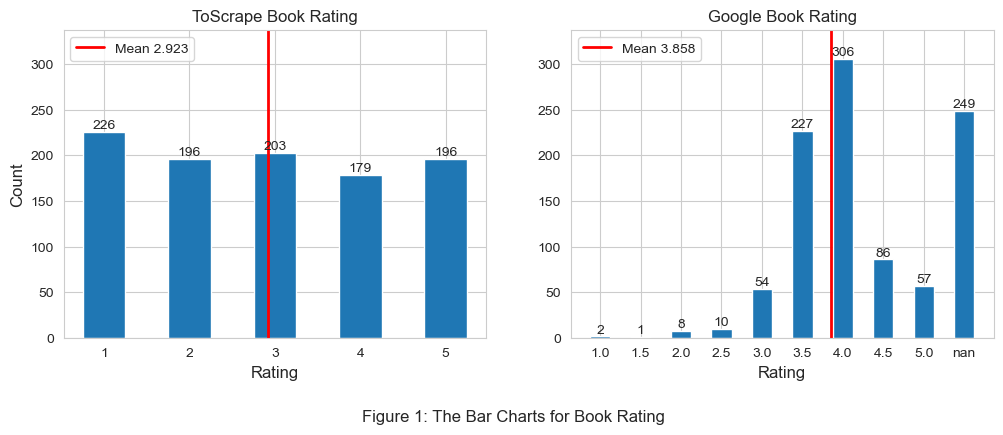

In [103]:
scrape_rating_info = book_info["Rating"].value_counts(dropna=False).sort_index()
scrape_rating_mean = book_info["Rating"].mean()
google_rating_info = book_info["Google Rating"].value_counts(dropna=False).sort_index()
google_rating_mean = book_info["Google Rating"].mean()

fig, (ax_s, ax_g) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12, 4)
fig.text(
    s="Figure 1: The Bar Charts for Book Rating",
    x =0.5,
    y= -0.1,
    ha="center",
    fontsize=12
)

bars = ax_s.bar(
    [str(item) for item in scrape_rating_info.index],
    scrape_rating_info.values,
    width = 0.5,
    align="center"
)
ax_s.axvline(
    scrape_rating_mean-1,
    color='red',
    linewidth=2,
    label=f"Mean {'{0:0.3f}'.format(scrape_rating_mean)}"
)
ax_s.bar_label(bars)
# enlarge y-axis space margin.
ax_s.set_ylim(top=ax_s.get_ylim()[1]+100)
ax_s.legend(loc='upper left')

ax_s.set_title("ToScrape Book Rating")
ax_s.set_xlabel("Rating", fontsize=12)
ax_s.set_ylabel("Count", fontsize=12)

bars = ax_g.bar(
    [str(item) for item in google_rating_info.index],
    google_rating_info.values,
    width=0.5,
    align="center"
)
ax_g.axvline(
    (google_rating_mean-1)*2,
    color='red',
    linewidth=2,
    label=f"Mean {'{0:0.3f}'.format(google_rating_mean)}")
ax_g.bar_label(bars)

ax_g.yaxis.set_tick_params(labelleft=True)
ax_g.legend(loc='upper left')

ax_g.set_title("Google Book Rating")
ax_g.set_xlabel("Rating", fontsize=12)

pass

 ### Book Rating Number
 As the number of reviews in ToScrape dataset is fixed to 0, here applies the Google datasets only. According to the relative figures, the rating number is an essential factor influencing the rating.

 Figure 2 indicates that the number of rating highly concentrated on the beginning of these ranges, which means most of the books have a tendency to receive fewer ratings. In other part of ranges, the rating number is generally uniformly distributed, which means the dataset covers the popular and not popular ones, if argues that the rating number is relevant to the sales. Furthermore, the rating reviewed by a small amount of users cannot reflect a reasonable comment of the majority. Considering the magnitude of the dataset, this report do not apply a data cleaning to drop some unreasonable data.

Figure 3 shows that the ratings with more rating number cluster at the 3.5 and 4 points. There are progressively fewer books in the vertical periphery section, which means fewer books have higher or lower scores. All extreme scores such as 5.0 or 1.0 - 2.5 points are not typical, considering lack of comments mentioned above.

Therefore, the rating number is an essential factor influencing the rating. Scores are close to upper middle level (3.0 - 4.5 points) under numerous comments, but exists extreme examples under sporadic comments.

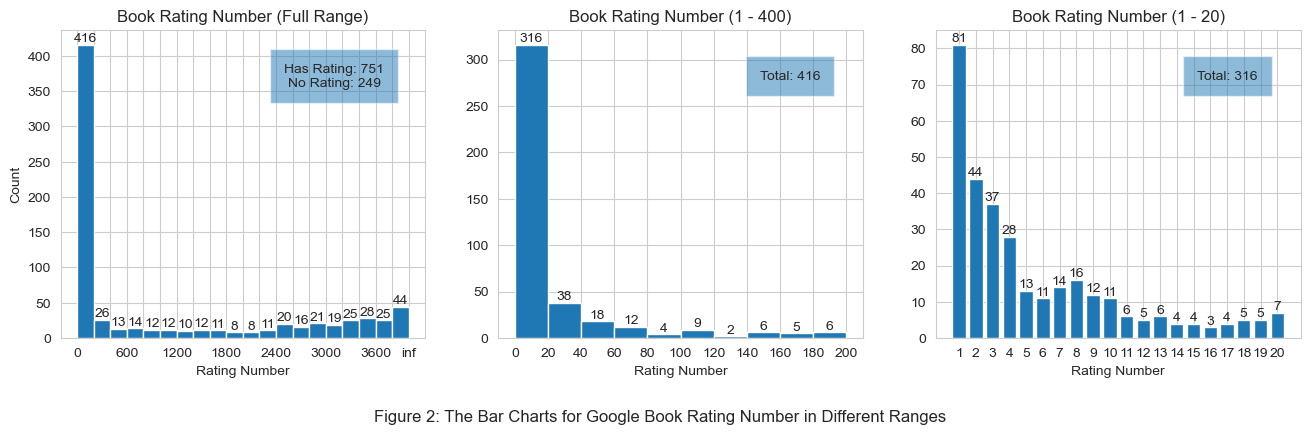

In [105]:
rating_info = book_info["Google Rating Count"]
rating_count_info = rating_info.value_counts(bins=list(range(0, 4000, 200))+[math.inf]).sort_index()
small_rating_count_info = rating_info.value_counts(bins=list(range(0, 200+20, 20))).sort_index()
smaller_rating_count_info = rating_info[rating_info.between(0, 20, inclusive="both")].value_counts().sort_index()

fig2, (ax_r1, ax_r2, ax_r3) = plt.subplots(1, 3)
fig2.set_size_inches(16, 4)
fig2.text(
    s="Figure 2: The Bar Charts for Google Book Rating Number in Different Ranges",
    x =0.5,
    y= -0.1,
    ha="center",
    fontsize=12,
)

bars = ax_r1.bar(
    [str(int(item.left)) for item in rating_count_info.index],
    rating_count_info.values,
    width=1,
    align="edge",
)
ax_r1.bar_label(bars)

# set the last tick into "inf".
ax_r1.set_xticks(list(ax_r1.get_xticks()) + [list(ax_r1.get_xticks())[-1] + 1])
plt.draw()
labels = [item.get_text() for item in ax_r1.get_xticklabels()[:-1]] + ["inf"]
ax_r1.set_xticklabels(labels)
# set the tick margin.
for idx, label in enumerate(ax_r1.xaxis.get_ticklabels()[:-1]):
    label.set_visible(idx%3==0)

ax_r1.set_title("Book Rating Number (Full Range)")
ax_r1.set_xlabel("Rating Number")
ax_r1.set_ylabel("Count")
ax_r1.text(
    x=0.75,
    y=0.85,
    s=(f"Has Rating: {rating_info.dropna().count()}\n"
       f"No Rating: {rating_info.isna().sum()}"),
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax_r1.transAxes,
    bbox={
        'facecolor': 'tab:blue',
        'alpha': 0.5,
        'pad': 10,
    }
)

bars = ax_r2.bar(
    [str(int(item.left)) for item in small_rating_count_info.index],
    small_rating_count_info.values,
    width=1,
    align="edge",
)
_ = ax_r2.bar_label(bars)

# set the last tick into range right.
ax_r2.set_xticks(list(ax_r2.get_xticks()) + [list(ax_r2.get_xticks())[-1] + 1])
plt.draw()
labels = [item.get_text() for item in ax_r2.get_xticklabels()[:-1]] + [str(int(small_rating_count_info.index[-1].right))]
_ = ax_r2.set_xticklabels(labels)

ax_r2.set_title("Book Rating Number (1 - 400)")
ax_r2.set_xlabel("Rating Number")
ax_r2.text(
    x=0.80,
    y=0.85,
    s=f"Total: {small_rating_count_info.sum()}",
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax_r2.transAxes,
    bbox={
        'facecolor': 'tab:blue',
        'alpha': 0.5,
        'pad': 10,
    }
)

bars = ax_r3.bar(
    [str(int(item)) for item in smaller_rating_count_info.index],
    smaller_rating_count_info.values,
    align="center"
)
ax_r3.bar_label(bars)

ax_r3.set_title("Book Rating Number (1 - 20)")
ax_r3.set_xlabel("Rating Number")
ax_r3.text(
    x=0.80,
    y=0.85,
    s=f"Total: {smaller_rating_count_info.sum()}",
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax_r3.transAxes,
    bbox={
        'facecolor': 'tab:blue',
        'alpha': 0.5,
        'pad': 10,
    }
)

pass

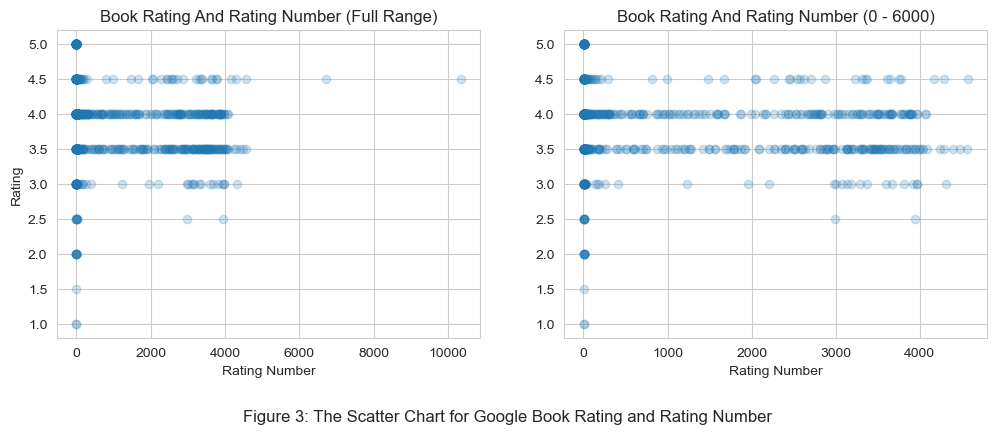

In [96]:
rating_info_all = book_info[book_info[["Google Rating", "Google Rating Count"]].notnull().all(axis=1)]
rating_info_small = rating_info_all[rating_info_all["Google Rating Count"].le(6000)]

fig3, (ax_a, ax_s) = plt.subplots(1, 2)
fig3.set_size_inches(12, 4)
fig3.text(
    s="Figure 3: The Scatter Charts for Google Book Rating and Rating Number",
    x =0.5,
    y= -0.1,
    ha="center",
    fontsize=12,
)

ax_a.scatter(rating_info_all["Google Rating Count"], rating_info_all["Google Rating"], alpha=0.2)
ax_a.set_title("Book Rating And Rating Number (Full Range)")
ax_a.set_xlabel("Rating Number")
ax_a.set_ylabel("Rating")

ax_s.scatter(rating_info_small["Google Rating Count"], rating_info_small["Google Rating"], alpha=0.2)
ax_s.set_title("Book Rating And Rating Number (0 - 6000)")
ax_s.set_xlabel("Rating Number")

pass

### Book Category
 According to the relative figures, the book category is not an essential factor influencing the rating.

 Figure 2 indicates that the categories are redundant and wide-ranging, with some emphasis on "Fiction" in Google dataset. However, the ToScrape dataset contains some dirty information of the categories, such as "Default" and "Add a comment". In some sub-categories, the two datasets exhibits similarity, such as "Young Adult", "Cooking", and "History". Thus, the further analysis focuses on the Google dataset, while the dataset do not cover all the categories, but the first one.

Figure 3 shows that there is no apparent special regularity in the rating distribution which follows the basic one. For large categories, ratings cluster at the upper middle level. For small categories, ratings scatter randomly above and below the baseline.

Therefore, the book category is not a determining element for the rating. Generally, it follows the regularity of the rating itself.

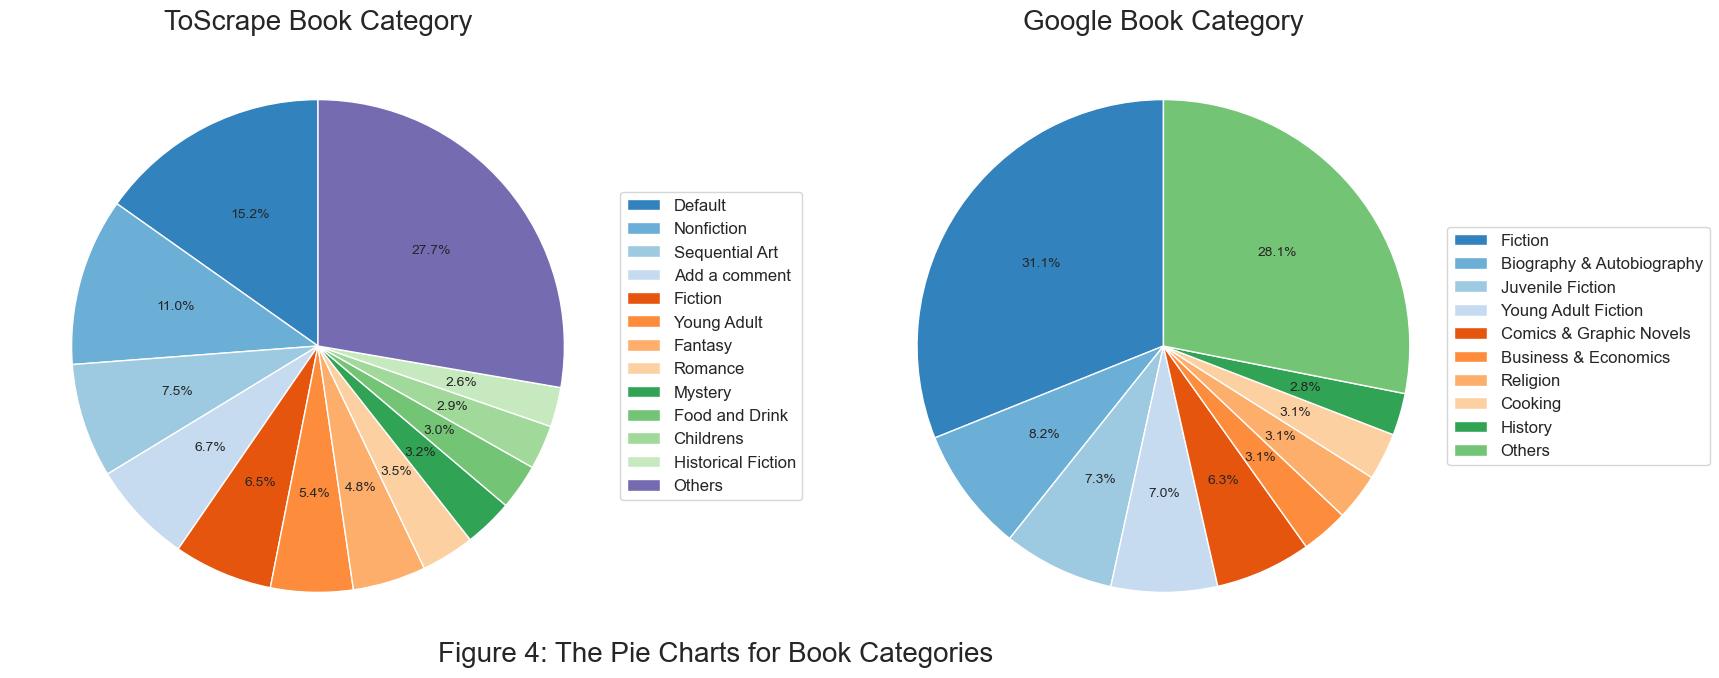

In [106]:
scrape_category_info = book_info["Book category"].value_counts()
google_category_info = book_info["Google Category"].value_counts()
other_threshold = 20

scrape_category_info = pandas.concat([
    scrape_category_info[scrape_category_info.ge(other_threshold)],
    pandas.Series(scrape_category_info[scrape_category_info.lt(other_threshold)].sum(), ["Others"])
])
google_category_info = pandas.concat([
    google_category_info[google_category_info.ge(other_threshold)],
    pandas.Series(google_category_info[google_category_info.lt(other_threshold)].sum(), ["Others"])
])

fig4, (ax_s, ax_g) = plt.subplots(1, 2)
fig4.set_size_inches(20, 8)
fig4.text(
    x=0.5,
    y=0.1,
    s="Figure 4: The Pie Charts for Book Categories",
    ha="center",
    fontsize=20
)
inner_colors = list(plt.get_cmap("tab20c").colors)

ax_s.pie(
    scrape_category_info.values,
    autopct='%1.1f%%',
    startangle=90,
    colors=inner_colors)
ax_s.set_title(
    "ToScrape Book Category",
    fontsize=20
)
ax_s.legend(
    labels=scrape_category_info.index,
    bbox_to_anchor=(1.3, 0.5),
    loc="center right",
    fontsize=12
)

ax_g.pie(
    google_category_info.values,
    autopct='%1.1f%%',
    startangle=90,
    colors=inner_colors
)
ax_g.set_title(
    "Google Book Category",
    fontsize=20
)
ax_g.legend(
    labels=google_category_info.index,
    bbox_to_anchor=(1.4, 0.5),
    loc="center right",
    fontsize=12
)

pass

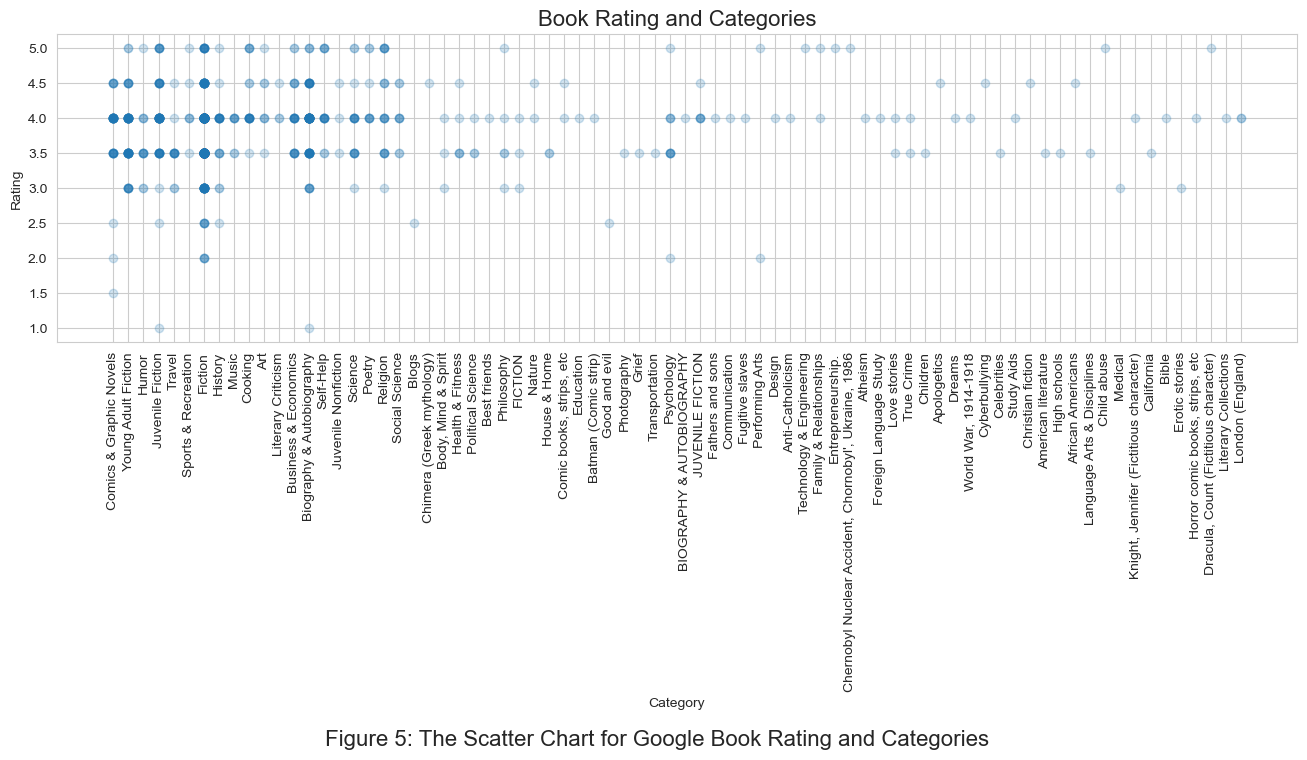

In [164]:
category_info = book_info[book_info[['Google Category', "Google Rating"]].notnull().all(axis=1)]

fig5, ax = plt.subplots()
fig5.set_size_inches(16, 4)
fig5.text(
    x=0.5,
    y=-0.9,
    s="Figure 5: The Scatter Chart for Google Book Rating and Categories",
    ha="center",
    fontsize=16
)

ax.scatter(category_info["Google Category"], category_info["Google Rating"], alpha=0.2)
ax.set_title("Book Rating and Categories", fontsize=16)
ax.set_xlabel("Category")
ax.set_ylabel("Rating")
plt.xticks(rotation=90)

pass

### Book Author
According to the relative figures, the book author is an essential factor influencing the rating. As ToScrape dataset does not provide author information, here discuss only Google dataset.

Figure 5 indicates that different authors have very different average ratings. Here selects authors who have more than two books in the datasets, which alleviates the data deviations. For example, Daniel James Brown's next book, who achieves the highest rating mark, is more likely to be perceived as a high-quality book with high rating scores.

Therefore, the book rating depends the book author to some extent.

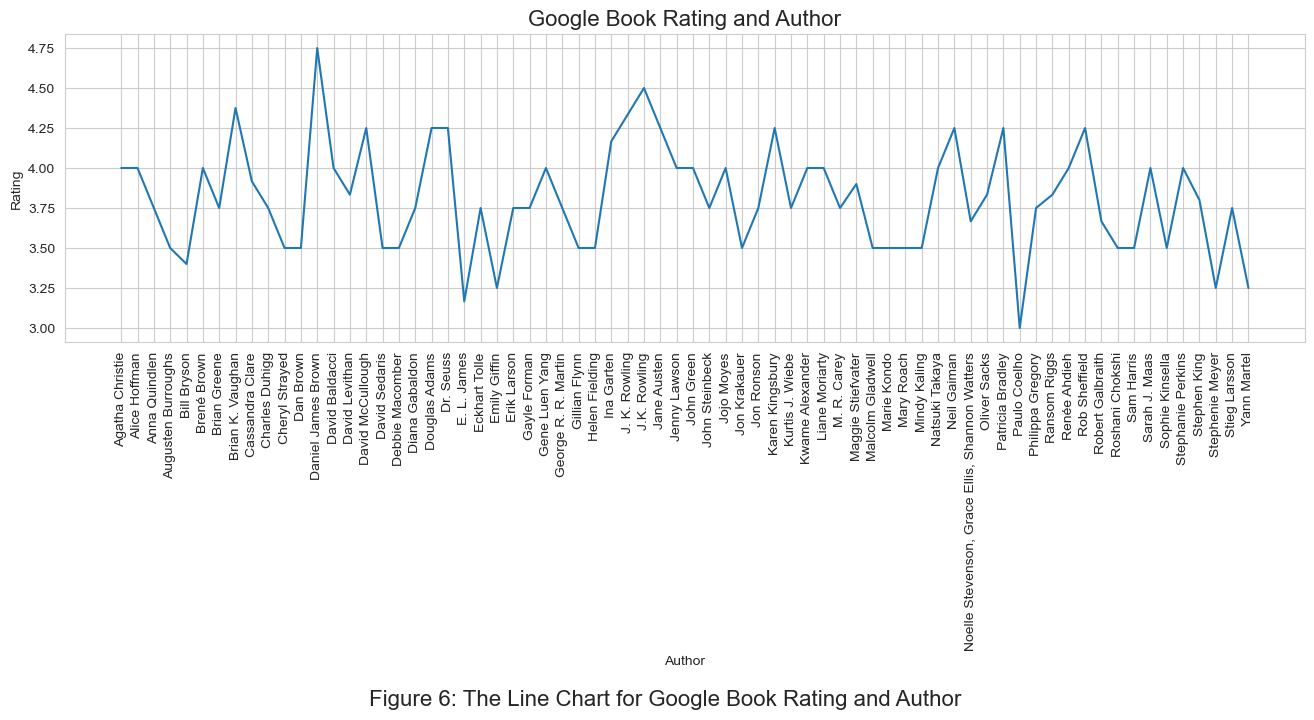

In [165]:
author_info = book_info[book_info[['Google Author', "Google Rating"]].notnull().all(axis=1)]
author_info = author_info[author_info[['Google Author']].duplicated(keep=False)]
author_info = author_info.groupby(['Google Author'])['Google Rating'].mean()

fig6, ax = plt.subplots()
fig6.set_size_inches(16, 4)
fig6.text(
    x=0.5,
    y=-0.8,
    s="Figure 6: The Line Chart for Google Book Rating and Author",
    ha="center",
    fontsize=16
)

ax.plot(author_info.index, author_info.values)
ax.set_title("Google Book Rating and Author", fontsize=16)
ax.set_xlabel("Author")
ax.set_ylabel("Rating")
plt.xticks(rotation=90)

pass

### Other Factors
In these two datasets, there are still some columns which do not under analysis, such as price and published time. Future work may focus on more valuable factors in more multi-source datasets.

### Conclusion
Through analysis and figure illustrations, this report states that the rating number and author do influence the rating, but book category is less impactful.